In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
seed = 42

passengers = pd.read_csv("titanic_augmented.csv", dtype={"Pclass": str})

In [5]:
num_passengers = len(passengers)

print(f"Number of passengers: {num_passengers}")

Number of passengers: 891


# Handling Null Values

In [6]:
passengers.isna().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [7]:
num_null_age = passengers.Age.isna().sum()
num_null_cabin = passengers.Cabin.isna().sum()
num_null_embarked = passengers.Embarked.isna().sum()
num_null_cabin_room_number = passengers.cabin_room_number.isna().sum()

print(f"Age: {num_null_age}/{num_passengers} ({round(num_null_age/num_passengers*100, 3)}%) are null")
print(f"Cabin: {num_null_cabin}/{num_passengers} ({round(num_null_cabin/num_passengers*100, 3)}%) are null")
print(f"Embarked: {num_null_embarked}/{num_passengers} ({round(num_null_embarked/num_passengers*100, 3)}%) are null")
print(f"cabin_room_number: {num_null_cabin_room_number}/{num_passengers} ({round(num_null_cabin_room_number/num_passengers*100, 3)}%) are null")

Age: 177/891 (19.865%) are null
Cabin: 687/891 (77.104%) are null
Embarked: 2/891 (0.224%) are null
cabin_room_number: 691/891 (77.553%) are null


## Cabin and cabin_room_number

In [8]:
passengers = passengers.drop(columns=['Cabin', 'cabin_room_number'])

## Embarked

In [9]:
passenger_embarked_counts = passengers.Embarked.value_counts()

print(f"{passenger_embarked_counts.S}/{num_passengers} ({round(passenger_embarked_counts.S/num_passengers*100, 3)}%) of passengers embarked from port S")
print(f"{passenger_embarked_counts.C}/{num_passengers} ({round(passenger_embarked_counts.C/num_passengers*100, 3)}%) of passengers embarked from port C")
print(f"{passenger_embarked_counts.Q}/{num_passengers} ({round(passenger_embarked_counts.Q/num_passengers*100, 3)}%) of passengers embarked from port Q")

644/891 (72.278%) of passengers embarked from port S
168/891 (18.855%) of passengers embarked from port C
77/891 (8.642%) of passengers embarked from port Q


In [10]:
passengers.groupby(["Sex", "Pclass"]).Embarked.apply(lambda p: p.mode()[0])

Sex     Pclass
female  1         S
        2         S
        3         S
male    1         S
        2         S
        3         S
Name: Embarked, dtype: object

In [11]:
passengers["Embarked"] = passengers.Embarked.fillna("S")

## Age

In [12]:
passengers.groupby(["Sex", "Pclass"]).Age.apply(lambda p: p.mean())

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [13]:
passengers["Age"] = passengers["Age"].fillna(passengers.groupby(["Sex", "Pclass"]).Age.transform(lambda p: p.mean()))

## cabin_deck

In [14]:
string_columns = passengers.select_dtypes(include="object")

string_columns.head()

,Pclass,Name,Sex,Ticket,Embarked,title,title_group,cabin_deck
0,3,"Braund, Mr. Owen Harris",male,A/5 21171,S,Mr,Mr,Unknown
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C,Mrs,Mrs,C
2,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S,Miss,Miss,Unknown
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S,Mrs,Mrs,C
4,3,"Allen, Mr. William Henry",male,373450,S,Mr,Mr,Unknown


In [15]:
string_columns.cabin_deck.value_counts()

cabin_deck
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

In [16]:
num_unkown_cabin_deck = len(passengers.query("cabin_deck == 'Unknown'"))

print(f"{num_unkown_cabin_deck}/{num_passengers} ({round(num_unkown_cabin_deck/num_passengers*100, 3)}%) have an unkown cabin_deck")

687/891 (77.104%) have an unkown cabin_deck


In [17]:
passengers = passengers.drop(columns=['cabin_deck'])

In [18]:
passengers.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Embarked             0
name_length          0
title                0
title_group          0
family_size          0
is_alone             0
ticket_group_size    0
fare_per_person      0
age_fare_ratio       0
booking_reference    0
service_id           0
cabin_score          0
name_word_count      0
dtype: int64

# Feature Selection

In [19]:
passengers.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'name_length', 'title',
       'title_group', 'family_size', 'is_alone', 'ticket_group_size',
       'fare_per_person', 'age_fare_ratio', 'booking_reference', 'service_id',
       'cabin_score', 'name_word_count'],
      dtype='object')

## Useless Identifiers (PassengerId, service_id, Name, booking_reference, and Ticket)

In [20]:
passengers.select_dtypes(exclude="float").nunique()

PassengerId          891
Survived               2
Pclass                 3
Name                 891
Sex                    2
SibSp                  7
Parch                  7
Ticket               681
Embarked               3
name_length           50
title                 17
title_group            5
family_size            9
is_alone               2
ticket_group_size      7
booking_reference    681
service_id           891
name_word_count        8
dtype: int64

In [21]:
passengers[["PassengerId", "service_id", "Name", "booking_reference", "Ticket"]]

,PassengerId,service_id,Name,booking_reference,Ticket
0,1,221958,"Braund, Mr. Owen Harris",92490,A/5 21171
1,2,771155,"Cumings, Mrs. John Bradley (Florence Briggs Th...",15655423,PC 17599
2,3,231932,"Heikkinen, Miss. Laina",90218500,STON/O2. 3101282
3,4,465838,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2493079,113803
4,5,359178,"Allen, Mr. William Henry",59517148,373450
...,...,...,...,...,...
886,887,538661,"Montvila, Rev. Juozas",83757278,211536
887,888,498929,"Graham, Miss. Margaret Edith",91664020,112053
888,889,680466,"Johnston, Miss. Catherine Helen ""Carrie""",55618889,W./C. 6607
889,890,673695,"Behr, Mr. Karl Howell",94737372,111369


In [22]:
passengers = passengers.drop(columns=["PassengerId", "service_id", "Name", "booking_reference", "Ticket"])

## is_alone

In [23]:
print(f"Unique is_alone among SibSp == 0 and Parch == 0: {passengers[(passengers['SibSp'] == 0) & (passengers['Parch'] == 0)]['is_alone'].unique()}")
print(f"Unique is_alone among SibSp != 0 or Parch != 0: {passengers[(passengers['SibSp'] != 0) | (passengers['Parch'] != 0)]['is_alone'].unique()}")

Unique is_alone among SibSp == 0 and Parch == 0: [1]
Unique is_alone among SibSp != 0 or Parch != 0: [0]


In [24]:
passengers = passengers.drop(columns=["is_alone"])

## family_size

In [25]:
np.all(passengers.family_size == passengers.SibSp + passengers.Parch + 1)

np.True_

In [26]:
passengers = passengers.drop(columns=["family_size"])

## age_fare_ratio

In [27]:
age_fare_mask = np.isclose(
    passengers.age_fare_ratio,
    np.where(
        passengers.Fare != 0,
        passengers.Age / passengers.Fare,
        0
    )
)

mode_age = passengers.groupby(["Sex", "Pclass"])["Age"].transform(lambda p: p.mode()[0])

mode_exception = passengers.Age == mode_age

np.all(age_fare_mask | mode_exception)

np.False_

In [28]:
passengers = passengers.drop(columns=["age_fare_ratio"])

## fare_per_person

In [29]:
np.all(
    round(passengers.fare_per_person, 3) == round(passengers.Fare/passengers.ticket_group_size, 3)
)

np.True_

In [30]:
passengers = passengers.drop(columns=["fare_per_person"])

## title

In [31]:
passengers.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [32]:
passengers.title_group.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [33]:
mismatched_titles = passengers[(passengers.apply(lambda p: p["title_group"] in p["title"], axis=1)) & (passengers.title_group != passengers.title)]

print(f"Number of mismatched titles: {len(mismatched_titles)}")

Number of mismatched titles: 0


In [34]:
passengers.title.value_counts()

title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [35]:
passengers.title_group.value_counts()

title_group
Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: count, dtype: int64

In [36]:
passengers = passengers.drop(columns=["title"])

## Sex

In [37]:
for title_group in passengers.title_group.unique():
    print(f"Number of sexes among {title_group}: {len(passengers[(passengers['title_group'] == title_group)].Sex.unique())}")

Number of sexes among Mr: 1
Number of sexes among Mrs: 1
Number of sexes among Miss: 1
Number of sexes among Master: 1
Number of sexes among Other: 2


In [38]:
passengers.query("title_group == 'Other'").Sex.value_counts()

Sex
male      20
female     7
Name: count, dtype: int64

In [39]:
passengers = passengers.drop(columns=["Sex"])

## Multicolinearity (name_word_count)

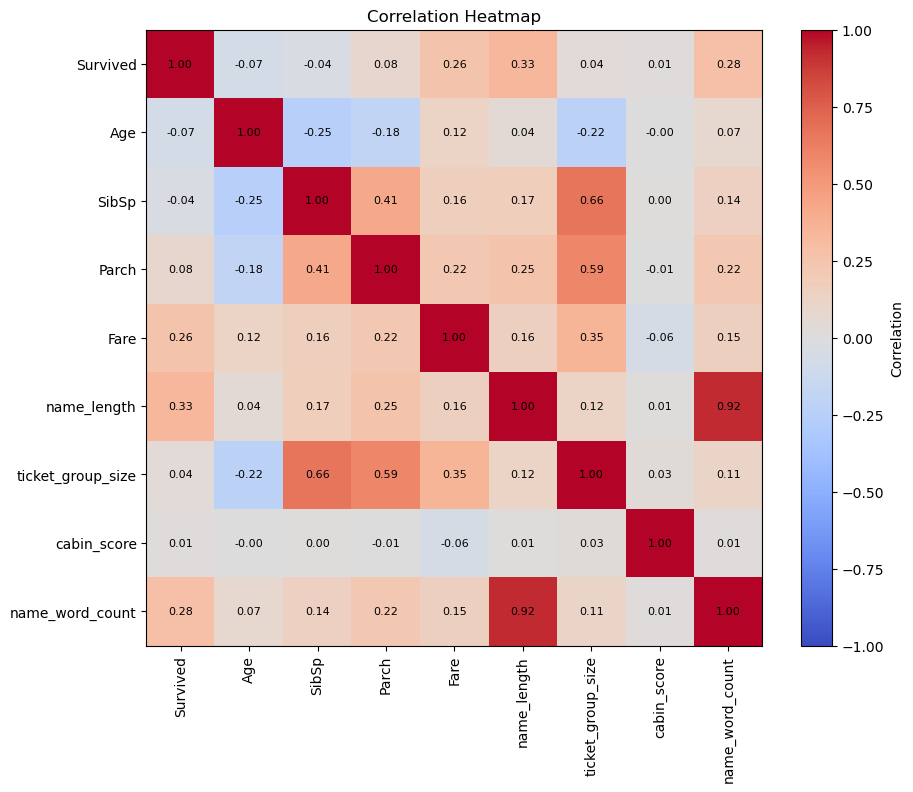

In [40]:
passengers_numeric = passengers.select_dtypes(include="number")

corr = passengers_numeric.corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation")

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.title("Correlation Heatmap")
plt.show()

In [41]:
def calculate_vif(data):
    return pd.DataFrame({
        "feature": data.columns,
        "VIF": [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    })

X_numeric = passengers.select_dtypes(include="number").drop(columns=["Survived"], errors="ignore")

max_vif = 999

while True:
    
    vif_data = calculate_vif(X_numeric)
    max_vif = vif_data['VIF'].max()
    
    if max_vif <= 10:
        break

    largest_multicoliearity = vif_data.sort_values("VIF", ascending=False).iloc[0]["feature"]
    X_numeric = X_numeric.drop(columns=[largest_multicoliearity])

    print(f"Feature to Remove: {largest_multicoliearity} with VIF={round(max_vif, 2)}")

print("\nFeatures to Not Removed:")
print(calculate_vif(X_numeric))

Feature to Remove: name_word_count with VIF=76.35

Features to Not Removed:
             feature       VIF
0                Age  4.923761
1              SibSp  2.247123
2              Parch  1.939682
3               Fare  1.705725
4        name_length  6.416126
5  ticket_group_size  5.923240
6        cabin_score  3.437662


In [42]:
passengers = passengers.drop(columns=["name_word_count"])

# Taking a look at the final passengers dataframe

In [43]:
passengers.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,name_length,title_group,ticket_group_size,cabin_score
0,0,3,22.000000,1,0,7.2500,S,23,Mr,1,6.134152
1,1,1,38.000000,1,0,71.2833,C,51,Mrs,1,4.182430
2,1,3,26.000000,0,0,7.9250,S,22,Miss,1,9.327285
3,1,1,35.000000,1,0,53.1000,S,44,Mrs,2,8.660639
4,0,3,35.000000,0,0,8.0500,S,24,Mr,1,0.452187
5,0,3,26.507589,0,0,8.4583,Q,16,Mr,1,0.263670
6,0,1,54.000000,0,0,51.8625,S,23,Mr,1,3.764634
7,0,3,2.000000,3,1,21.0750,S,30,Master,4,8.105533
8,1,3,27.000000,0,2,11.1333,S,49,Mrs,3,9.872761
9,1,2,14.000000,1,0,30.0708,C,35,Mrs,2,1.504169


In [44]:
passengers.describe()

,Survived,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.318643,0.523008,0.381594,32.204208,26.965208,1.787879,4.956762
std,0.486592,13.281103,1.102743,0.806057,49.693429,9.281607,1.361142,2.915177
min,0.000000,0.420000,0.000000,0.000000,0.000000,12.000000,1.000000,0.046320
25%,0.000000,21.750000,0.000000,0.000000,7.910400,20.000000,1.000000,2.325861
50%,0.000000,26.507589,0.000000,0.000000,14.454200,25.000000,1.000000,4.954913
75%,1.000000,36.000000,1.000000,0.000000,31.000000,30.000000,2.000000,7.479345
max,1.000000,80.000000,8.000000,6.000000,512.329200,82.000000,7.000000,9.997177


# Splitting Data

In [45]:
X_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Embarked", "name_length", "title_group", "ticket_group_size", "cabin_score"]
X = passengers[X_columns]

y = passengers.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed) # Stratified

# Dummy Encoding

In [46]:
categorical_columns = ["Pclass", "Embarked", "title_group"]

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)

X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Standardizing

In [66]:
numeric_columns = ["Age", "SibSp", "Parch", "Fare", "name_length", "ticket_group_size", "cabin_score"]

scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Taking a look at the final X_train dataframe

In [76]:
X_train.head()

,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,title_group_Miss,title_group_Mr,title_group_Mrs,title_group_Other
486,0.409455,0.536677,-0.451483,1.240397,2.175192,0.183190,1.441830,False,False,False,True,False,False,True,False
238,-0.799932,-0.464720,-0.451483,-0.436028,0.453849,-0.572186,1.404873,True,False,False,True,False,True,False,False
722,0.333869,-0.464720,-0.451483,-0.383310,0.131098,-0.572186,-0.958719,True,False,False,True,False,True,False,False
184,-1.933732,-0.464720,1.951631,-0.192999,0.884185,-0.572186,-1.293701,False,True,False,True,True,False,False,False
56,-0.648758,-0.464720,-0.451483,-0.436028,-1.052325,-0.572186,-0.348058,True,False,False,True,True,False,False,False


In [74]:
X_train.describe()

,Age,SibSp,Parch,Fare,name_length,ticket_group_size,cabin_score
count,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02,6.680000e+02
mean,5.318434e-18,-1.329608e-17,7.977650e-18,-5.318434e-18,1.063687e-17,4.254747e-17,-5.318434e-18
std,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00,1.000749e+00
min,-2.204332e+00,-4.647201e-01,-4.514834e-01,-6.574426e-01,-1.590245e+00,-5.721859e-01,-1.669374e+00
25%,-5.920682e-01,-4.647201e-01,-4.514834e-01,-4.909431e-01,-7.295735e-01,-5.721859e-01,-9.328323e-01
50%,-2.138479e-01,-4.647201e-01,-4.514834e-01,-3.651669e-01,-1.916540e-01,-5.721859e-01,1.471626e-02
75%,5.606288e-01,5.366767e-01,-4.514834e-01,-1.428587e-02,3.462656e-01,1.831899e-01,8.667354e-01
max,3.810857e+00,7.546455e+00,6.757861e+00,1.014610e+01,5.940629e+00,3.960069e+00,1.722734e+00


# Linear Discriminant Analysis

## Best Subsets Selections:

In [94]:
import itertools

predictors = X_train.columns.tolist()
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#model = LinearDiscriminantAnalysis()

i = 0
best_subsets = []
best_accuracy_values = np.zeros(len(predictors))

while i < len(predictors) : 
    subsets = list(itertools.combinations(predictors, i+1))

    for subset in subsets :
        #accuracy = np.mean(cross_val_score(estimator=model, X=X_train[list(subset)], y=y_train, cv=skf, scoring='accuracy'))
        model = LinearDiscriminantAnalysis()
        model.fit(X_train[list(subset)], y_train)
        y_preds = model.predict(X_train[list(subset)])
        accuracy = accuracy_score(y_train, y_preds)
        
        if accuracy > best_accuracy_values[i] : 
            best_accuracy_values[i] = accuracy
            if len(best_subsets) <= i :
                best_subsets.append(list(subset))
            else : 
                best_subsets[i] = (list(subset))
    
    i = i + 1

print("Best accuracies for each number of predictors:\n")
i = 0 
while i < len(best_subsets) :
    print(str(i+1)+" predictors - accuracy: "+str(best_accuracy_values[i])+ " predictors: "+str(best_subsets[i]))
    i=i+1


Best accuracies for each number of predictors:

1 predictors - accuracy: 0.7904191616766467 predictors: ['title_group_Mr']
2 predictors - accuracy: 0.8038922155688623 predictors: ['SibSp', 'title_group_Mr']
3 predictors - accuracy: 0.8143712574850299 predictors: ['SibSp', 'Pclass_3', 'title_group_Mr']
4 predictors - accuracy: 0.8203592814371258 predictors: ['ticket_group_size', 'Pclass_3', 'title_group_Miss', 'title_group_Mr']
5 predictors - accuracy: 0.8248502994011976 predictors: ['SibSp', 'Parch', 'Pclass_3', 'title_group_Mr', 'title_group_Other']
6 predictors - accuracy: 0.8278443113772455 predictors: ['Age', 'SibSp', 'Parch', 'Pclass_3', 'title_group_Mr', 'title_group_Mrs']
7 predictors - accuracy: 0.8323353293413174 predictors: ['Age', 'Fare', 'ticket_group_size', 'Pclass_3', 'title_group_Mr', 'title_group_Mrs', 'title_group_Other']
8 predictors - accuracy: 0.8323353293413174 predictors: ['Age', 'SibSp', 'Parch', 'name_length', 'Pclass_3', 'Embarked_S', 'title_group_Mr', 'title_g

## 10-fold CV and Test Data accuracy comparisons of all 15 best subset selections:

In [125]:
CV = []
test_accuracies = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

i = 0
while i < len(best_subsets) : 
    subset = best_subsets[i]
    model = LinearDiscriminantAnalysis()
    
    CV_accuracy = np.mean(cross_val_score(estimator=model, X=X_train[subset], y=y_train, cv=skf, scoring='accuracy'))
    CV.append(CV_accuracy)

    model = LinearDiscriminantAnalysis()
    model.fit(X_train[subset], y_train)
    y_preds = model.predict(X_test[subset])
    test_data_accuracy = accuracy_score(y_test, y_preds)
    test_accuracies.append(test_data_accuracy)

    print("Predictor Count: "+str(i+1)+" - 10 fold CV average accuracy: "+str(CV[i])+" - Test Data accuracy: "+str(test_accuracies[i]))
    
    i=i+1

Predictor Count: 1 - 10 fold CV average accuracy: 0.7903889642695613 - Test Data accuracy: 0.757847533632287
Predictor Count: 2 - 10 fold CV average accuracy: 0.8038896426956128 - Test Data accuracy: 0.7982062780269058
Predictor Count: 3 - 10 fold CV average accuracy: 0.8128448665762098 - Test Data accuracy: 0.8116591928251121
Predictor Count: 4 - 10 fold CV average accuracy: 0.817345092718227 - Test Data accuracy: 0.7937219730941704
Predictor Count: 5 - 10 fold CV average accuracy: 0.8143374038896427 - Test Data accuracy: 0.8161434977578476
Predictor Count: 6 - 10 fold CV average accuracy: 0.8172998643147895 - Test Data accuracy: 0.8116591928251121
Predictor Count: 7 - 10 fold CV average accuracy: 0.8202849389416553 - Test Data accuracy: 0.8161434977578476
Predictor Count: 8 - 10 fold CV average accuracy: 0.8217774762550881 - Test Data accuracy: 0.8251121076233184
Predictor Count: 9 - 10 fold CV average accuracy: 0.8217774762550881 - Test Data accuracy: 0.8116591928251121
Predictor Co

In [126]:
ordered_cv_values = sorted(list(set(CV)))
ordered_test_set_accuracies = sorted(list(set(test_accuracies)))

print("Ordered unqiue values of 10-fold CV average accuracies:")
for val in ordered_cv_values :
    print(val)

print("\n\nOrdered unqiue values of test data prediction accuracies:")
for val in ordered_test_set_accuracies :
    print(val)

Ordered unqiue values of 10-fold CV average accuracies:
0.7903889642695613
0.8038896426956128
0.8128448665762098
0.8143374038896427
0.8172998643147895
0.817345092718227
0.8202623247399365
0.8202849389416553
0.8217774762550881
0.823270013568521


Ordered unqiue values of test data prediction accuracies:
0.757847533632287
0.7937219730941704
0.7982062780269058
0.8116591928251121
0.8161434977578476
0.820627802690583
0.8251121076233184
0.8295964125560538


## Predictor Selection from previous metrics:  
We can see from the metrics above, that there is only 1 subset selection (the one with 12 predictors) which has the highest 10 - fold CV accuracy (accuracy of 0.823270013568521), this subset selection also has the highest test data predictions accuracy (0.8295964125560538). So this subset selection is the most accurate.  
  
However, we would like to prioiritize model interprebility as well. We also consider 10-fold cv to be more reliable than test data predictions accuracy, because it provides a more robust and less biased estimate of the prediction error and the models performance on true out of sample data. We can then see that for all the subset selections with the 2nd highest 10 - fold CV (0.8217774762550881), the one with the fewest predictors has 8 predictors. The one with 8 predictors also has the 2nd highest test data predictions accuracy. All models with higher test prediction accuracy have many predictors (12 or more) and the difference between the best and 2nd best test data prediction accuracies is very small. Remember, only one subset selection has a higher 10-fold CV accuracy than the one with 8 predictors, and thats the subset selection with 12 predictors. From this we choose the subset selection with 8 predictors to be one of most accurate but also interpretible subsets.

In [127]:
print("Best subset selection (considering interprebility) has 8 predictors:")
best_subset = best_subsets[7]
print(best_subset)

Best subset selection (considering interprebility) has 8 predictors:
['Age', 'SibSp', 'Parch', 'name_length', 'Pclass_3', 'Embarked_S', 'title_group_Mr', 'title_group_Other']


## Hyperparameter Tuning using 10-fold CV

In [128]:
param_grid = [
    {'solver': ['svd'], 'shrinkage': [None]},
    {'solver': ['lsqr'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]},
    {'solver': ['eigen'], 'shrinkage': ['auto', 0.1, 0.5, 0.9]}
]

model = LinearDiscriminantAnalysis()
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv_strategy,
)

grid_search.fit(X_train[best_subset], y_train)
best_model = grid_search.best_estimator_
print("best parameters: "+str(grid_search.best_params_))

best parameters: {'shrinkage': None, 'solver': 'svd'}


## Final LDA Model results, evaluation and visualization:

Our final model uses the 8 predictors: 'Age', 'SibSp', 'Parch', 'name_length', 'Pclass_3', 'Embarked_S', 'title_group_Mr', and 'title_group_Other'.

In [122]:
y_preds = best_model.predict(X_test[best_subset])
test_data_predictions_accuracy = accuracy_score(y_test, y_preds)

print("Test Data Prediction Accuracy Score: "+str(test_data_predictions_accuracy))

Test Data Prediction Accuracy Score: 0.8251121076233184


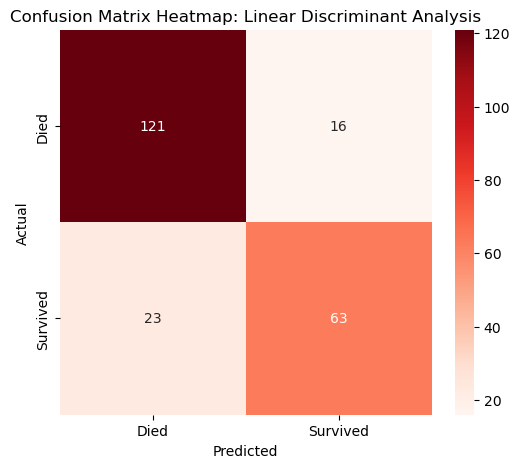

In [123]:
heat_plot(best_model, X_test[best_subset], y_test, "Linear Discriminant Analysis")

---
# Logistic Regression

## Feature Selection Based on Importance

In [50]:
def model_scores(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    mse = mean_squared_error(y_test, y_pred_prob)
    print("Test MSE:", mse)

lr = LogisticRegression(max_iter=1000, random_state=42)

lr.fit(X_train, y_train)

model_scores(lr, X_test, y_test)

print("\nParameters being used:")
print(lr.get_params())

Accuracy: 0.8161434977578476
Test MSE: 0.1376682340580819

Parameters being used:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.0, 'max_iter': 1000, 'n_jobs': None, 'penalty': 'deprecated', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [51]:
coefs = lr.coef_[0]

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefs,
    'importance': np.abs(coefs)
}).sort_values(by='importance', ascending=False)

print(feature_importance)

              feature  coefficient  importance
12     title_group_Mr    -2.172863    2.172863
8            Pclass_3    -1.876118    1.876118
14  title_group_Other    -1.129932    1.129932
7            Pclass_2    -0.925666    0.925666
13    title_group_Mrs     0.847302    0.847302
0                 Age    -0.490594    0.490594
11   title_group_Miss     0.450701    0.450701
1               SibSp    -0.390773    0.390773
10         Embarked_S    -0.345542    0.345542
3                Fare     0.307301    0.307301
6         cabin_score     0.225843    0.225843
4         name_length     0.199307    0.199307
9          Embarked_Q     0.178286    0.178286
2               Parch    -0.172264    0.172264
5   ticket_group_size    -0.113821    0.113821


In [52]:
def print_low_importance_features(feature_importance):
    max_importance = feature_importance.importance.max()
    low_importance_features = feature_importance[feature_importance.importance < 0.1 * max_importance]
    
    print(f"Features with <10% of max importance ({round(max_importance, 3)}):\n")
    print(low_importance_features)

print_low_importance_features(feature_importance)

Features with <10% of max importance (2.173):

             feature  coefficient  importance
4        name_length     0.199307    0.199307
9         Embarked_Q     0.178286    0.178286
2              Parch    -0.172264    0.172264
5  ticket_group_size    -0.113821    0.113821


### Removing ticket_group_size for Logistic Regression

In [53]:
columns_to_drop = ["ticket_group_size"]

X_train_trimmed = X_train.drop(columns=columns_to_drop)
X_test_trimmed = X_test.drop(columns=columns_to_drop)

lr.fit(X_train_trimmed, y_train)

model_scores(lr, X_test_trimmed, y_test)

Accuracy: 0.8161434977578476
Test MSE: 0.13684782231816287


In [54]:
coefs = lr.coef_[0]

feature_importance = pd.DataFrame({
    'feature': X_train_trimmed.columns,
    'coefficient': coefs,
    'importance': np.abs(coefs)
}).sort_values(by='importance', ascending=False)

print(feature_importance)

              feature  coefficient  importance
11     title_group_Mr    -2.169704    2.169704
7            Pclass_3    -1.897146    1.897146
13  title_group_Other    -1.130471    1.130471
6            Pclass_2    -0.940440    0.940440
12    title_group_Mrs     0.849449    0.849449
0                 Age    -0.487527    0.487527
10   title_group_Miss     0.462527    0.462527
1               SibSp    -0.444755    0.444755
9          Embarked_S    -0.352915    0.352915
3                Fare     0.270780    0.270780
5         cabin_score     0.220643    0.220643
2               Parch    -0.218113    0.218113
4         name_length     0.210022    0.210022
8          Embarked_Q     0.174195    0.174195


In [55]:
print_low_importance_features(feature_importance)

Features with <10% of max importance (2.17):

       feature  coefficient  importance
4  name_length     0.210022    0.210022
8   Embarked_Q     0.174195    0.174195


### Removing name_length for Logistic Regression

In [56]:
columns_to_drop = ["name_length"]

X_train_trimmed = X_train_trimmed.drop(columns=columns_to_drop)
X_test_trimmed = X_test_trimmed.drop(columns=columns_to_drop)

lr.fit(X_train_trimmed, y_train)

model_scores(lr, X_test_trimmed, y_test)

Accuracy: 0.8161434977578476
Test MSE: 0.1383369656744183


In [57]:
coefs = lr.coef_[0]

feature_importance = pd.DataFrame({
    'feature': X_train_trimmed.columns,
    'coefficient': coefs,
    'importance': np.abs(coefs)
}).sort_values(by='importance', ascending=False)

print(feature_importance)

              feature  coefficient  importance
10     title_group_Mr    -2.243403    2.243403
6            Pclass_3    -1.954964    1.954964
12  title_group_Other    -1.103366    1.103366
11    title_group_Mrs     1.086492    1.086492
5            Pclass_2    -0.997286    0.997286
0                 Age    -0.484856    0.484856
9    title_group_Miss     0.435376    0.435376
1               SibSp    -0.415901    0.415901
8          Embarked_S    -0.320403    0.320403
3                Fare     0.260376    0.260376
4         cabin_score     0.224960    0.224960
2               Parch    -0.195569    0.195569
7          Embarked_Q     0.130918    0.130918


In [58]:
print_low_importance_features(feature_importance)

Features with <10% of max importance (2.243):

      feature  coefficient  importance
2       Parch    -0.195569    0.195569
7  Embarked_Q     0.130918    0.130918


### Removing Parch for Logistic Regression

In [59]:
columns_to_drop = ["Parch"]

X_train_trimmed = X_train_trimmed.drop(columns=columns_to_drop)
X_test_trimmed = X_test_trimmed.drop(columns=columns_to_drop)

lr.fit(X_train_trimmed, y_train)

model_scores(lr, X_test_trimmed, y_test)

Accuracy: 0.8161434977578476
Test MSE: 0.14074473812291488


In [60]:
coefs = lr.coef_[0]

feature_importance = pd.DataFrame({
    'feature': X_train_trimmed.columns,
    'coefficient': coefs,
    'importance': np.abs(coefs)
}).sort_values(by='importance', ascending=False)

print(feature_importance)

              feature  coefficient  importance
9      title_group_Mr    -2.130876    2.130876
5            Pclass_3    -2.024775    2.024775
11  title_group_Other    -1.033202    1.033202
4            Pclass_2    -1.008228    1.008228
10    title_group_Mrs     0.958847    0.958847
8    title_group_Miss     0.496182    0.496182
0                 Age    -0.468544    0.468544
1               SibSp    -0.460531    0.460531
7          Embarked_S    -0.336636    0.336636
2                Fare     0.220246    0.220246
3         cabin_score     0.216000    0.216000
6          Embarked_Q     0.178478    0.178478


In [61]:
print_low_importance_features(feature_importance)

Features with <10% of max importance (2.131):

      feature  coefficient  importance
6  Embarked_Q     0.178478    0.178478


## Hyperparameter Tuning

In [71]:
cv_grid_logistic_regression = [   
    {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     "penalty": ["l2"],
     "solver": ["liblinear", "lbfgs"],
     "class_weight": [None, "balanced"]}
]

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=seed), cv_grid_logistic_regression, cv=5, scoring='accuracy')

grid.fit(X_train_trimmed, y_train)

best_lr = grid.best_estimator_

model_scores(best_lr, X_test_trimmed, y_test)

print("\nBest Parameters:", grid.best_params_)

C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalt

Accuracy: 0.8161434977578476
Test MSE: 0.14074473812291488

Best Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\gnand\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalt

The default parameters are the best parameters.

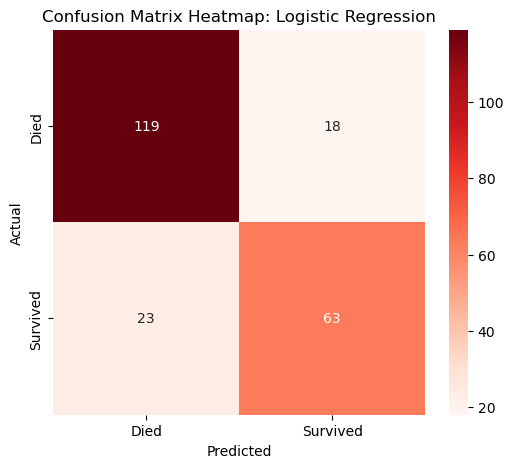

In [63]:
def heat_plot(model, X_test, y_test, model_label):

    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    labels = ["Died", "Survived"]
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix Heatmap: {model_label}")
    plt.show()

heat_plot(best_lr, X_test_trimmed, y_test, "Logistic Regression")

---